In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.visualizer.main import Visualizer
from scipy.spatial import Delaunay
from scipy.spatial import Voronoi, voronoi_plot_2d


## Algorytm Naiwny Byby

In [4]:
def matrix(a,b,c):
     det = (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])
     return det

In [5]:
import math

class HPlane:
    eps = 10**(-9)
    def __init__(self, a , b) : 
        self.p = np.array([a[0], a[1]]); 
        b = np.array([b[0], b[1]])
        self.pq = b-a
        self.angle = math.atan2(self.pq[1], self.pq[0])
    
    def out(self,c):
        return np.cross(self.pq, c-self.p) < -self.eps
    
    def __lt__(self, h):
        return self.angle < h.angle
    
    def inter(self, t):
        a = np.cross((t.p - self.p), t.pq) / np.cross(self.pq, t.pq)
        return self.p + (self.pq*a)




In [6]:
from collections import deque 

def hplanes_intersection(H : [HPlane], M =3):
    bbox = np.array(
        [[M, M] , [-M, M], [-M, -M], [M, -M]]
    )
    for i in range(3): 
        H.append(HPlane(bbox[i], bbox[i+1]))
    
    H.append(HPlane(bbox[-1], bbox[0]))
    H.sort()
    dq  = deque()
    count  = 0
    for  i in range(len(H)):


       
        while count >1 and H[i].out(dq[count-1].inter(dq[count-2])):
            dq.pop()
            count-=1
        
        while count > 1 and H[i].out(dq[0].inter(dq[1])):
            dq.popleft()
            count-=1
        
        if count > 0 and abs(np.cross(H[i].pq, dq[count-1].pq)) < HPlane.eps:
            if (np.dot(H[i].pq, dq[count-1].pq) <  0):
                return None
            if H[i].out(dq[count-1].p):
                dq.pop()
                count-=1
            else :
                continue
        dq.append(H[i])
        count+=1
    

    while count > 2 and dq[0].out(dq[count-1].inter(dq[count-2])):
        dq.pop()
        count-=1
    
    while count > 2 and dq[count-1].out(dq[0].inter(dq[1])):
        dq.popleft()
        count-=1
    
    if count < 3:
        return None
    
    poly = []
    for i in range(count-1):
        cp = dq[i].inter(dq[i+1])
        poly.append((cp[0], cp[1]))
    
    cp = dq[-1].inter(dq[0])
    poly.append((cp[0], cp[1]))
    
    return poly
    


    
    

In [7]:



def naive_voronoi(points, inf = 5):
    polygons = []
    for v in points:
        halfplanes = []
        for u in points:
            if u == v:
                continue
            mid_point = np.array([v[0]/2 + u[0]/2, v[1]/2 + u[1]/2])
            uv = np.subtract(u,v)
            uv_perp = np.array([uv[1],-uv[0]])
            bpoint = mid_point + uv_perp
            if(matrix(mid_point,bpoint,v) > 0 ):
                halfplanes.append(HPlane(mid_point, bpoint))
            else :
                halfplanes.append(HPlane(bpoint,  mid_point))

        polygon = hplanes_intersection(halfplanes,inf)
        polygons.append(polygon)
    return polygons

        
        



In [8]:
def draw_voronoi_poly(polygons, points, colors = False):
    vis = Visualizer()
    for pol in polygons:
        if colors:
            vis.add_polygon(pol, fill = True, color = (np.random.sample(),np.random.sample(),np.random.sample()))
        else:
            vis.add_polygon(pol, fill = False)
    
    vis.add_point(points, color = "black")
    vis.show(xrange=3.5, y_range=3.5)


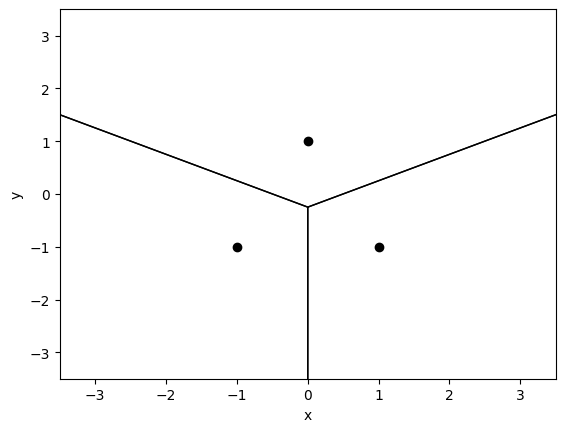

In [116]:
mouse = [(-1.0, -1.0), (1.0,-1.0), (0,1)];
P = naive_voronoi( mouse,10)
draw_voronoi_poly(P, mouse)



In [20]:
def naive_voronoi_animation(points, inf = 5):
    polygons = []
    vis = Visualizer()
    vis.axis_equal()
    bounds = [((-inf, -inf), (inf, -inf)),
    ((inf, -inf), (inf, inf)),
    ((inf, inf), (-inf, inf)),
    ((-inf, inf), (-inf, -inf))]
    vis.add_line_segment(bounds, color = "black")
    vis.add_point(points, color = "black", zorder = 3)



    for v in points:
        halfplanes = []
        segments = []
        start = vis.add_point(v, color = "green")
        for u in points:
            if u == v:
                continue
            current = vis.add_line_segment((u,v), color = "red")
            mid_point = np.array([v[0]/2 + u[0]/2, v[1]/2 + u[1]/2])
            uv = np.subtract(u,v)
            uv_perp = np.array([uv[1],-uv[0]])
            bpoint = mid_point + uv_perp
            if(matrix(mid_point,bpoint,v) > 0 ):
                halfplanes.append(HPlane(mid_point, bpoint))
            else :
                halfplanes.append(HPlane(bpoint,  mid_point))
            
            segments.append(vis.add_line((mid_point, bpoint), color = "red", linestyle = "dashed"))
            vis.remove_figure(current)

        polygon = hplanes_intersection(halfplanes,inf)
        polygons.append(polygon)
        
        P = vis.add_point(polygon, color = "red")
        for s in segments:
            vis.remove_figure(s)
        area = vis.add_polygon(polygon , fill = True, color = "red")
        vis.remove_figure(P)
        vis.add_polygon(polygon, fill = False, color = "blue")
        vis.remove_figure(area)
    return vis, polygons

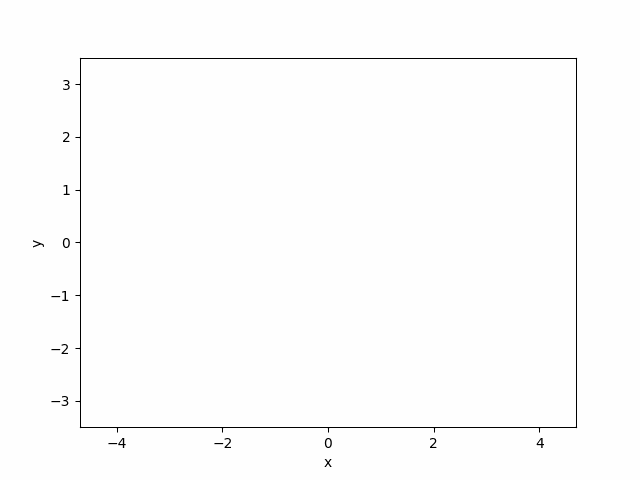

In [21]:
points = np.random.uniform(-2,2, [3,2])
vis, P = naive_voronoi_animation(points.tolist())
vis.show_gif(interval=500, x=3.5,y=3.5)


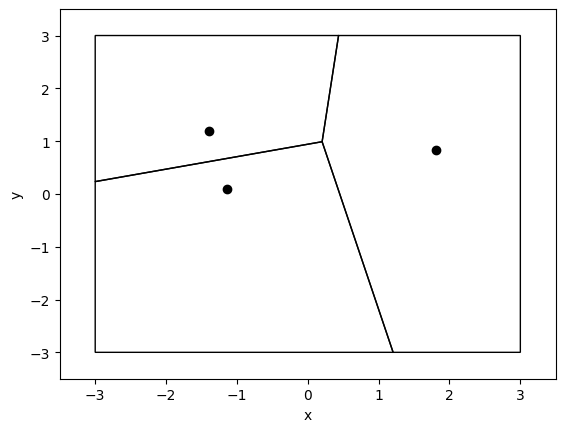

In [12]:
draw_voronoi_poly(P, points)

In [14]:

def center(vertices):
    v,u,w = vertices[0],vertices[1],vertices[2]
    d = 2*(np.cross(v,u)-np.cross(v,w) + np.cross(u,w))
    xp = np.dot(v,v)*(u[1] - w[1]) + np.dot(u,u)*(w[1] - v[1]) + np.dot(w,w)*(v[1] - u[1])
    yp = np.dot(v,v)*(w[0]-u[0]) + np.dot(u,u)*(v[0] - w[0]) + np.dot(w,w)*(u[0] - v[0])
    return np.array([xp/d, yp/d])

In [65]:
eps = 10**(-9)


def voronoiDelenuay(points, inf = 20):
    points = np.array(points)
    segments = []
    
   

    if len(points)  == 2:
        mid1 = (points[0]+points[1])*0.5
        n = (points[1]-points[0])
        perpendicual = np.array([n[1], -n[0]])
        segments.append((mid1 + perpendicual*10000, (mid1  -perpendicual*10000)))
        return segments

    # sprawdzam współliniowość

    colinear = True

    for i in range(len(points)-2):
        det = matrix(points[i], points[i+1], points[i+2])
        if abs(det)>eps:
            colinear = False


    if colinear:
        for i in range(len(points)-1):
            mid1 = (points[i]+points[i+1])*0.5
            n = (points[i+1]-points[i])
            perpendicual = np.array([n[1], -n[0]])
            segments.append((mid1 + perpendicual*10000, mid1 - perpendicual*10000))
        
        return segments;

    D = Delaunay(points)
    T = D.simplices

    centers = []
    for t in T:
        centers.append(center(points[t]))
    

    visited = [False for i in range(len(T))]

    for i in range(len(T)):
        if visited[i]:
            continue
        visited[i] = True
        N = D.neighbors[i]
        vertices = points[T[i]]
        for j in range(3):
            if N[j] == -1:
                a = vertices[(j+1)%3]
                b = vertices[(j+2)%3]
                mid = (a+b)*0.5
                n = (b-a)
                perpendicual = np.array([n[1], -n[0]])
                segments.append((centers[i], perpendicual*100000.0 + mid))
            else:
                ncenter = centers[N[j]]
                segments.append((ncenter, centers[i])) 
    
    return segments





In [107]:
def voronoiDelenuayAnimation(points, inf = 20):
    points = np.array(points)
    segments = []
    
    vis = Visualizer()
    vis.add_point(points, color = "black", zorder = 3)

    if len(points)  == 2:
        mid1 = (points[0]+points[1])*0.5
        n = (points[1]-points[0])
        perpendicual = np.array([n[1], -n[0]])
        segments.append((mid1 + perpendicual*10000, (mid1  -perpendicual*10000)))
        vis.add_line_segment(segments[-1], color = "black")
        return segments, vis

    # sprawdzam współliniowość

    colinear = True

    for i in range(len(points)-2):
        det = matrix(points[i], points[i+1], points[i+2])
        if abs(det)>eps:
            colinear = False


    if colinear:
        for i in range(len(points)-1):
            mid1 = (points[i]+points[i+1])*0.5
            n = (points[i+1]-points[i])
            perpendicual = np.array([n[1], -n[0]])
            segments.append((mid1 + perpendicual*10000, mid1 - perpendicual*10000))
            vis.add_line_segment(segments[-1])
        
        return segments, vis;

    D = Delaunay(points)
    T = D.simplices


    mesh = []
    for t in T:
        mesh.append(points[t])



    vis.add_polygon(mesh, fill = False, color = (0.6,0.6, 0.6))

    centers = []
    for t in T:
        centers.append(center(points[t]))
        vis.add_point(centers[-1], color = "red")
    

    visited = [False for i in range(len(T))]

    for i in range(len(T)):
        if visited[i]:
            continue
        visited[i] = True
        N = D.neighbors[i]
        vertices = points[T[i]]
        for j in range(3):
            if N[j] == -1:
                a = vertices[(j+1)%3]
                b = vertices[(j+2)%3]
                mid = (a+b)*0.5
                n = (b-a)
                perpendicual = np.array([n[1], -n[0]])
                segments.append((centers[i], perpendicual*100000.0 + mid))
                vis.add_line_segment(segments[-1], color = "black")
            else:
                ncenter = centers[N[j]]
                segments.append((ncenter, centers[i])) 
                vis.add_line_segment(segments[-1], color = "black")

    
    return segments, vis




In [113]:
def draw_voronoi_edges(E, P, inf=3.5):
    vis = Visualizer()
    vis.add_point(P, color = "black")
    vis.add_line_segment(E, color = "black")
    vis.show(inf, inf)

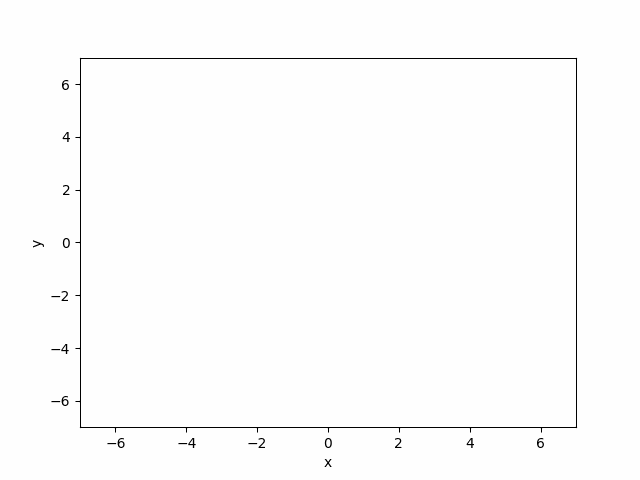

In [110]:
points = [(-1,-1), (1,-1), (0,1), (4,4), (-3,3)]
E,vis = voronoiDelenuayAnimation(points)
vis.show_gif(x=7, y = 7, interval = 500)

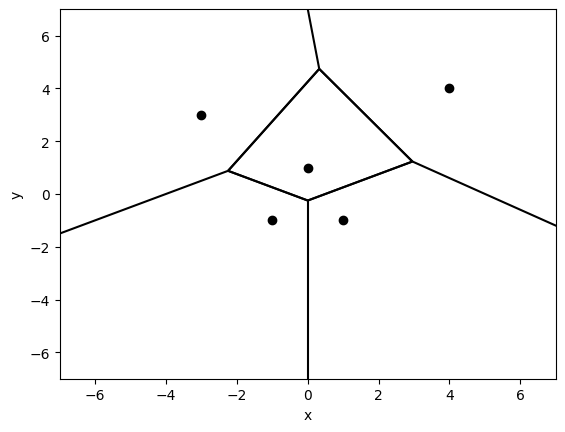

In [114]:
draw_voronoi_edges(E, points, 7)

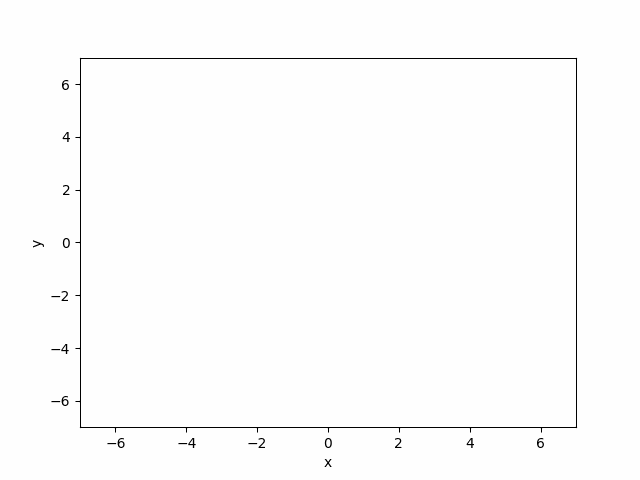

In [ ]:
points = [(-1,-1), (1,-1), (0,1), (4,4), (-3,3)]
E,vis = voronoiDelenuayAnimation(points)
vis.show_gif(x=7, y = 7, interval = 500)

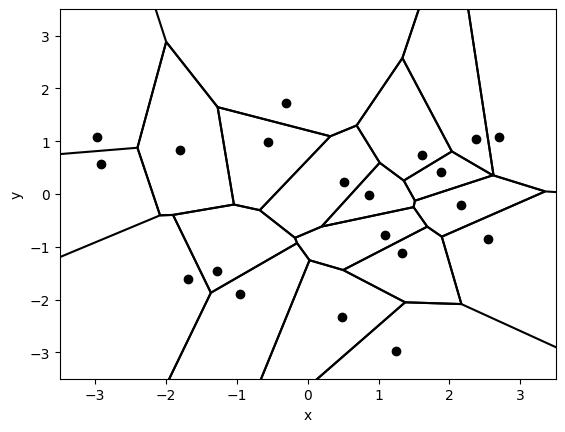

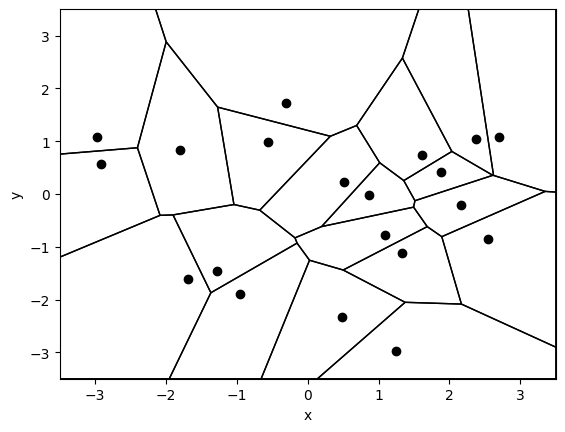

In [115]:
points = np.random.uniform(-3,3, [20,2])
E = voronoiDelenuay(points)
P = naive_voronoi(points.tolist())
draw_voronoi_edges(E, points)
draw_voronoi_poly(P, points)